In [1]:
from utils.libraries import *
from utils.objects import *
from utils.functions import *
from definitions import *

## Collecting & Preparing the data

### Setting up the configuration

In [2]:
# Se utiliza un rango de 20 años para la extraccion de datos económicos
timeframe = 365*20
today = datetime.today()
end = today.strftime("%Y-%m-%d")
start = (today - dt.timedelta(days=timeframe)).strftime("%Y-%m-%d")
periods = "W"

medidas = ["mean", "median", "mode", "Min", "Percentil_25", "Percentil_75","Max", "var", "std", "skew", "kurt"]

ROOT_PATH = Path(ROOT_PATH)
config_paths = [
    "config\Market_Data_Config.csv",
    "config\Economic_Data_Config.csv",
    "config\Calc_Data_Config.csv"
]
market_config = ROOT_PATH.joinpath(config_paths[0])
economic_config = ROOT_PATH.joinpath(config_paths[1]).abspath()
calc_config = ROOT_PATH.joinpath(config_paths[2]).abspath()

target_list = pd.read_csv(market_config, sep=";", header=0).loc[:, "Codigo"].to_list()

markets_used = ['SPY', 'GDX', 'BND']

target = "SP500"

# ML random seed
seed = 2

extract = True

cutoff_date = "2023-01-01"

### Loading and extracting the data

In [3]:
# Initialize the Economic Data Analyzer class
eda = EconomicDataAnalyzer()

In [4]:
# Load the Market Data
print("> Load the market data config")
market = eda.read_config(market_config)
market_dict = eda.convert_to_dictionary(markets_used=markets_used)
market_dict = market_dict['Market']
# Load the economic data config
print("> Load the economic data config")
econ = eda.read_config(economic_config)
fred_series_dict = eda.convert_to_dictionary(markets_used=None)
fred_series_dict = fred_series_dict["Indicador"]
calc = eda.read_config(calc_config)
series_calc_dict = eda.convert_to_dictionary(markets_used=None)
series_calc_dict = series_calc_dict["Indicador"]
# Setting up the indicator dictionaries
print("> Setting up the indicator dictionaries")
indicators = {}
for ind in list(econ["Tipo"].unique()):
    indicators[ind] = econ[econ["Tipo"] == ind]["Indicador"].to_list()
if extract == True:
    # Extracting the indicator data
    print("> Extracting the indicator data")
    indicators_df = eda.indicator_extraction(fred_series_dict, series_calc_dict, root_path=ROOT_PATH)
    # Extracting the market data
    print("> Extracting the market data")
    stocks = list(market_dict.keys())
    market_df = eda.market_extraction(stocks, start, end, root_path=ROOT_PATH)
else:
    print("No data extraction, reading data from data file")
    path = ROOT_PATH.joinpath('data', 'raw', 'indicators_df.csv')
    indicators_df = pd.read_csv(path)
    path = ROOT_PATH.joinpath('data', 'raw', 'market_df.csv')
    market_df = pd.read_csv(path)

> Load the market data config
> Load the economic data config
> Setting up the indicator dictionaries
> Extracting the indicator data
   -->Extracting 10-Year Treasury Yield...
   -->Extracting 2-Year Treasury Yield...
   -->Extracting Federal Funds Effective Rate...
   -->Extracting 1-Month Treasury Yield...
   -->Extracting 3-Month Treasury Yield...
   -->Extracting 5-Year Treasury Yield...
   -->Extracting 20-Year Treasury Yield...
   -->Extracting 30-Year Treasury Yield...
   -->Extracting 15-Year Mortgage Rate...
   -->Extracting 30-Year Mortgage Rate...
   -->Extracting Unemployment Rate...
   -->Extracting GDP...
   -->Extracting Real GDP...
   -->Extracting CPI...
   -->Extracting PPI...
   -->Extracting Consumer Confidence Index...
   -->Extracting Government Debt...
   -->Extracting Debt Service vs Disposable Income...
   -->Extracting US Dollar Index...
   -->Extracting Corporate Profits...
   -->Extracting EBIT...
   -->Extracting Retained Earnings...
   -->Extracting Build

## Preparing the data

### Data cleaning

In [5]:
# Cleaning the indicator data
print("> Cleaning the indicator data")
df_indicators, df_indicators_cum, df_indicators_diff, df_indicators_rets, df_indicators_limpio = eda.limpiar_indicators(
    df_indicators=indicators_df, 
    indicator_dict=indicators, 
    resample=periods, 
    fill_method="ffill", 
    start=start, 
    end=end, 
    root_path=ROOT_PATH)
# Cleaning the market data
print("> Cleaning market data")
df_market, df_markets_rets, df_markets_cum, df_markets_diff  = eda.limpiar_markets(
    markets_dict=market_dict,
    df_markets=market_df,
    resample=periods, 
    fill_method="ffill", 
    start=start, 
    end=end, 
    root_path=ROOT_PATH)

> Cleaning the indicator data
> Cleaning market data


### Merge indicator and market data

In [6]:
list_market_dfs = [df_market,df_markets_rets,df_markets_cum,df_markets_diff]
list_indicators_dfs = [df_indicators_limpio,df_indicators_rets,df_indicators_cum,df_indicators_diff]

df_all_data, df_all_data_rets, df_all_data_cum, df_all_data_diff = eda.merge_data(list_market_dfs, list_indicators_dfs)

## Feature Engineering

### Remove Outliers 

In [7]:
df = eda.remove_outliers(df_all_data_rets)

### Adding features

In [8]:
df_all_data["CAPE Ratio"] = df_all_data["SP500"]/(df_all_data["Corporate Profits"]*0.01)
df["CAPE Ratio"] = df_all_data["SP500"]/(df_all_data["Corporate Profits"]*0.01)

# df_all_data["CAPE Ratio"].plot()
def trend_line(df, name, deg=2):
    coef = np.polyfit(range(0,len(df[name])), df[name], deg)
    x_trend = np.linspace(0,len(df[name]),len(df[name]))
    y_trend = np.polyval(coef, x_trend)
    df = pd.DataFrame(y_trend, index=df.index, columns=[name])
    return df

# df_all_data = pd.DataFrame()
df_all_data["SP_GDP"] = df_all_data["SP500"]/(df_all_data["GDP"]*.01)
df_all_data["SP_GDP_trend"] = trend_line(df_all_data, "SP_GDP", deg=5)
df["SP_GDP"] = df_all_data["SP500"]/(df_all_data["GDP"]*.01)
df["SP_GDP_trend"] = trend_line(df_all_data, "SP_GDP", deg=5)

# df_all_data = pd.DataFrame()
std = df_all_data["SP_GDP"].std()
df_all_data["SP_GDP_1std"] = df_all_data["SP_GDP_trend"] + (std)
df["SP_GDP_1std"] = df_all_data["SP_GDP_trend"] + (std)

# df_all_data = df_all_data.copy()
# df_ts = df_all_data.loc[:,df_all_data.columns.str.contains(f"t-")]
# df_all_data.drop(df_ts.columns,axis=1,inplace=True)
for ma in df_all_data.columns:
    df_all_data[f"{ma}_MA"] = df_all_data[[ma]].rolling(window=52).mean().fillna(method="ffill").fillna(method="bfill")
    df_all_data[f"{ma}_trend"] = trend_line(df_all_data[[ma]], ma, deg=6)
    df_all_data[f"{ma}_MA_trend_dif"] = df_all_data[f"{ma}_trend"] - df_all_data[f"{ma}_MA"]
    
    df[f"{ma}_MA"] = df_all_data[[ma]].rolling(window=52).mean().fillna(method="ffill").fillna(method="bfill")
    df[f"{ma}_trend"] = trend_line(df_all_data[[ma]], ma, deg=6)
    df[f"{ma}_MA_trend_dif"] = df_all_data[f"{ma}_trend"] - df_all_data[f"{ma}_MA"]

### Creating lags in the data

In [9]:
list_data_dfs = [df_all_data,df_all_data_rets,df_all_data_cum,df_all_data_diff]

df_all_lag_data, df_all_lag_data_rets, df_all_lag_data_cum, df_all_lag_data_diff = eda.lag_data(list_data_dfs, target, n_lags=12)

In [10]:
df = eda.remove_outliers(df_all_lag_data_rets)

## Data Preprocessing

In [11]:
econ_ml = Preprocessor()

### Feature Reduction

#### Feature selection by correlation

In [12]:
df_feat_corr = pd.DataFrame(df.corr().loc[target,:].sort_values(ascending=False))
df_feat_relevant_corr = df_feat_corr[(df_feat_corr[target]>0.05) | (df_feat_corr[target]<-0.05)]
df_feat_relevant_corr

,SP500
SP500,1.000000
1-Month Treasury Yield (t-10),0.079336
1-Month Treasury Yield (t-8),0.074586
1-Month Treasury Yield (t-9),0.074177
Government Debt to GDP (t-11),0.073239
...,...
PPI (t-10),-0.081348
Federal Funds Effective Rate (t-2),-0.085613
Federal Funds Effective Rate (t-1),-0.113812
Federal Funds Effective Rate,-0.122076


#### Indentifying the most important features

##### Splitting the data

##### Creating the baseline for feature importance

In [13]:
baseline_models = econ_ml.define_baseline_models()

X_train, X_test, y_train, y_test = econ_ml.train_test_split_data(data=df, target_col=target, test_size=0.15)
model_results, baseline_preds, best_model, best_model_name = econ_ml.baseline_ml(target, X_train, X_test, y_train, y_test, baseline_models)

Processing RandomForest
Processing GradientBoosting
Processing SVR
Processing KNeighborsRegressor
Processing XGBRegressor
--> We choose ['RandomForest' 'XGBRegressor'] as the best models due to their high scores and rmse


In [14]:
print("> Performing feature importance analysis")
df_top_data, feature_importance, top_feature_importance, score = econ_ml.feature_importance(target=target, 
                                                                                                  df_data=df.loc[:cutoff_date],
                                                                                                  model=best_model,
                                                                                                  accepted_importance=0.9)

> Performing feature importance analysis


#### Feature removal

In [15]:
def feature_removal(df, df_top_data, model_results, best_model_name, score):
    best_model_score = model_results.loc[best_model_name,"score"]
    if score > best_model_score*.8:
        print("We choose to remove "+str(len(df.columns)-len(df_top_data.columns))+" features")
        df = df_top_data.copy()
    else:
        print("We choose to keep the original df with "+str(len(df_top_data.columns))+" features")
    return df

In [16]:
df = feature_removal(df, df_top_data, model_results, best_model_name, score)

We choose to remove 237 features


## Performing Machine Learning

### Pick the best model

In [80]:
X_train, X_test, y_train, y_test = econ_ml.train_test_split_data(data=df, target_col=target, test_size=0.15)
model_results, baseline_preds, best_model, best_model_name = econ_ml.baseline_ml(target, X_train, X_test, y_train, y_test, baseline_models)

Processing RandomForest
Processing GradientBoosting
Processing SVR
Processing KNeighborsRegressor
Processing XGBRegressor
--> We choose ['RandomForest' 'XGBRegressor'] as the best models due to their high scores and rmse


In [59]:
baseline_models

{'RandomForest': RandomForestRegressor(),
 'GradientBoosting': GradientBoostingRegressor(),
 'SVR': SVR(),
 'KNeighborsRegressor': KNeighborsRegressor(),
 'XGBRegressor': XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
              reg_lambda=1, ...)}

### Define the grids

In [88]:
params_RandomForest = {
    "n_estimators": [120],
    "max_depth": [3,5,10,15,17],
    "max_features": ["sqrt", 3, 4]                          
    }

params_GradientBoosting = {
    'n_estimators': [50, 100, 150],  
    'learning_rate': [0.01, 0.05, 0.1],  
    'max_depth': [3, 5, 7],  
    }

params_XGBRegressor = {
    'n_estimators': [50, 100, 150],  
    'learning_rate': [0.01, 0.05, 0.1],  
    'max_depth': [3, 5, 7],  
    'min_child_weight': [1, 3, 5],  
    'subsample': [0.8, 0.9, 1.0],  
    'colsample_bytree': [0.8, 0.9, 1.0],  
    }

params_KNeighborsRegressor = {
    'n_neighbors': [3, 5, 7, 9],  
    'weights': ['uniform', 'distance'],  
    'p': [1, 2],  
    
    }

params_SVR = {
    'C': [0.1, 1.0, 10.0],  
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  
    'degree': [2, 3, 4],  
    'gamma': ['scale', 'auto', 0.1, 1.0],  
    }

baseline_params = {
    "RandomForest":params_RandomForest,
    "GradientBoosting":params_GradientBoosting,
    "SVR":params_SVR,
    "KNeighborsRegressor":params_KNeighborsRegressor,
    "XGBRegressor":params_XGBRegressor
}

def model_gridSearch(baseline_models,baseline_params,model_results,X_train,y_train,X_test,y_test,cross_val=5):
    y_test = y_test.copy()
    models_gridsearch = {}
    for name, model in baseline_models.items():
        if name in model_results.index.values:
            for mod,params in baseline_params.items():
                if name == mod:
                    models_gridsearch[mod] = GridSearchCV(model, params, cv=cross_val, scoring="neg_root_mean_squared_error", verbose=1, n_jobs=1)
                    models_gridsearch[mod].fit(X_train, y_train)
    best_grids = [(i, j.best_score_) for i, j in models_gridsearch.items()]
    best_grids = pd.DataFrame(best_grids, columns=["Grid", "Best score"]).sort_values(by="Best score", ascending=False)
    y_pred = models_gridsearch[best_grids.loc[0,"Grid"]].predict(X_test)
    y_pred = pd.DataFrame(y_pred, columns=[target+"_Prediction"],index=y_test.index)
    y_pred.index, y_test.index = pd.to_datetime(y_test.index), pd.to_datetime(y_test.index)
    model_pred = pd.concat([y_test, y_pred], axis=1)
    return models_gridsearch, best_grids, y_pred, y_test, model_pred

In [90]:
models_gridsearch, best_grids, y_pred, y_test, model_pred = model_gridSearch(baseline_models,baseline_params,model_results,X_train,y_train,X_test,y_test,cross_val=2)

Fitting 2 folds for each of 15 candidates, totalling 30 fits
Fitting 2 folds for each of 729 candidates, totalling 1458 fits


In [94]:
from joblib import dump
dump(models_gridsearch[best_grids.loc[0,"Grid"]], r'C:\Users\Joan Oliver\Documents\GitHub\Economic_Market_Forecasting\Economic_Market_Forecasting\EMF_webapp\EMF_project\models\best_model.joblib')

['C:\\Users\\Joan Oliver\\Documents\\GitHub\\Economic_Market_Forecasting\\Economic_Market_Forecasting\\EMF_webapp\\EMF_project\\models\\best_model.joblib']

In [101]:
X_test.index = pd.to_datetime(X_test.index)

In [102]:
full_test = pd.concat([model_pred, X_test], axis=1)

,SP500,SP500_Prediction,CorporateBonds,Gold,10-Year Treasury Yield,2-Year Treasury Yield,Federal Funds Effective Rate,5-Year Treasury Yield,20-Year Treasury Yield,30-Year Treasury Yield,...,10yTrea30yFRM (t-3),10yTrea30yFRM (t-4),10yTrea30yFRM (t-5),10yTrea30yFRM (t-6),10yTrea30yFRM (t-7),10yTrea30yFRM (t-8),10yTrea30yFRM (t-9),10yTrea30yFRM (t-10),10yTrea30yFRM (t-11),10yTrea30yFRM (t-12)
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-16,0.002026,0.003241,0.000704,0.013606,0.000000,0.007092,0.000000,0.007092,0.000000,0.012636,...,0.019401,0.027933,-0.027174,0.000000,0.016575,-0.010929,-0.026596,-0.015707,0.010582,-0.005072
2020-02-23,0.002026,0.000280,0.006333,0.013606,0.000000,0.007092,0.000000,0.007092,0.000000,0.003879,...,0.015135,0.019401,0.027933,-0.027174,0.000000,0.016575,-0.010929,-0.026596,-0.015707,0.010582
2020-03-01,-0.004077,0.000720,0.011189,0.013606,0.000000,0.003546,0.000000,0.007092,0.000000,-0.004878,...,0.013002,0.015135,0.019401,0.027933,-0.027174,0.000000,0.016575,-0.010929,-0.026596,-0.015707
2020-03-08,0.004050,0.002717,0.013523,0.013606,-0.021277,0.000000,0.004587,0.007092,0.030534,-0.006410,...,0.011936,0.013002,0.015135,0.019401,0.027933,-0.027174,0.000000,0.016575,-0.010929,-0.026596
2020-03-15,0.004050,0.004247,-0.001329,0.023800,-0.021277,0.000000,0.009174,0.007092,0.030534,-0.006410,...,0.015515,0.011936,0.013002,0.015135,0.019401,0.027933,-0.027174,0.000000,0.016575,-0.010929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-04,0.013646,0.002216,0.015257,-0.025349,0.017094,-0.004137,0.000000,0.021798,0.007916,0.000000,...,0.010563,0.010563,0.010563,0.007782,0.006575,0.005367,0.002952,-0.001878,-0.001878,-0.006708
2022-12-11,-0.004797,0.002799,-0.004626,-0.022288,-0.004058,0.011682,0.000000,0.021798,-0.007822,-0.004213,...,0.010563,0.010563,0.010563,0.010563,0.007782,0.006575,0.005367,0.002952,-0.001878,-0.001878
2022-12-18,-0.010958,0.002457,0.007244,-0.016168,-0.004058,0.011682,0.000000,0.021798,-0.007822,-0.004213,...,0.010563,0.010563,0.010563,0.010563,0.010563,0.007782,0.006575,0.005367,0.002952,-0.001878


In [64]:
best_grids = [(i, j.best_score_) for i, j in models_gridsearch.items()]
best_grids = pd.DataFrame(best_grids, columns=["Grid", "Best score"]).sort_values(by="Best score", ascending=False)
best_grids

,Grid,Best score
0,RandomForest,-0.012563
1,XGBRegressor,-0.012683


In [68]:
models_gridsearch[best_grids.loc[0,"Grid"]].best_estimator_.score(X_test, y_test)

-0.08156273370819211

In [81]:
y_pred = models_gridsearch[best_grids.loc[0,"Grid"]].predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=[target+"_Prediction"],index=y_test.index)
y_pred.index, y_test.index = pd.to_datetime(y_test.index), pd.to_datetime(y_test.index)

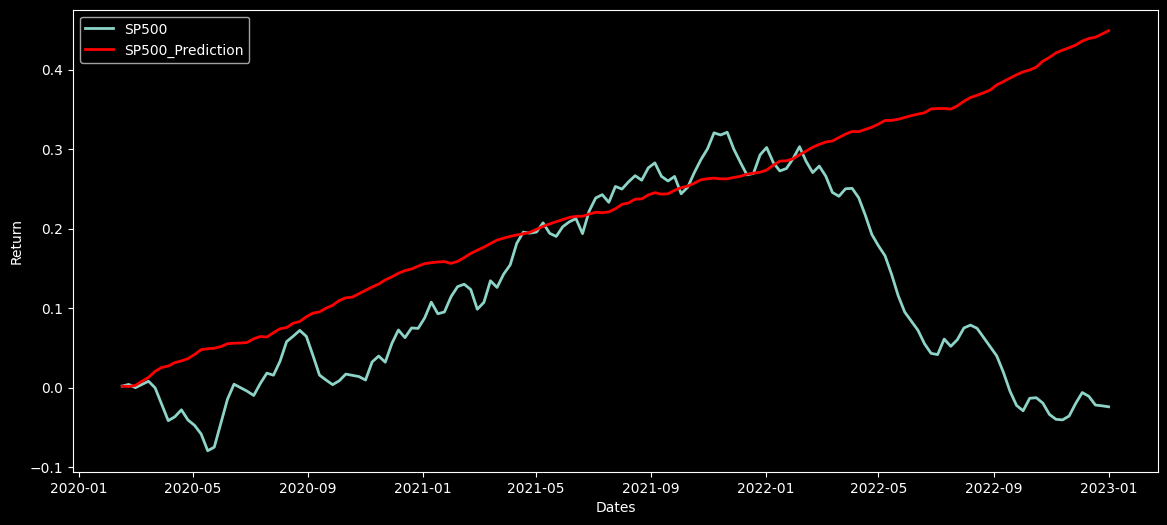

In [85]:
# plt.scatter(X_train, y_train, color='blue', label='Training Data')
plt.figure(figsize=(14,6))
plt.plot(y_test.cumsum(), linewidth=2, label=target)
plt.plot(y_pred.cumsum(), color='red', linewidth=2, label=target+'_Prediction')
plt.xlabel('Dates')
plt.ylabel('Return')
plt.legend()
plt.show()

In [22]:
grid_RandomForest = {
    "n_estimators": [120],
    "max_depth": [3,5,10,15,17],
    "max_features": ["sqrt", 3, 4]                          
    }

grid_GradientBoosting = {
    'n_estimators': [50, 100, 150],  # Number of boosting stages (trees)
    'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage to prevent overfitting
    'max_depth': [3, 5, 7],  # Maximum depth of the individual trees
    }

grid_XGBRegressor = {
    'n_estimators': [50, 100, 150],  # Number of boosting stages (trees)
    'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage to prevent overfitting
    'max_depth': [3, 5, 7],  # Maximum depth of the individual trees
    'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight needed in a child
    'subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for fitting the trees
    'colsample_bytree': [0.8, 0.9, 1.0],  # Fraction of features used for fitting the trees
    }

grid_KNeighborsRegressor = {
    'n_neighbors': [3, 5, 7, 9],  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
    # Add other hyperparameters you want to tune, such as 'algorithm', 'leaf_size', etc.
    }

grid_SVR = {
    'C': [0.1, 1.0, 10.0],  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Type of kernel function
    'degree': [2, 3, 4],  # Degree of the polynomial kernel function (used for 'poly' kernel)
    'gamma': ['scale', 'auto', 0.1, 1.0],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid' kernels
    }


In [45]:
pipe = Pipeline(steps=[
            ("selectkbest",SelectKBest()), 
            ("RandomForest", RandomForestRegressor())
            ])

grid_RandomForest = {
    "n_estimators": [120],
    "max_depth": [3,5,10,15,17],
    "max_features": ["sqrt", 3, 4]                          
    }

grid_RandomForest = {
    "n_estimators": [120],
    "max_depth": [3,5,10,15,17],
    "max_features": ["sqrt", 3, 4]                          
    }

models_gridsearch = {}

models_gridsearch = GridSearchCV("RandomForest",
                                        pipe,
                                        cv=10,
                                        scoring="accuracy",
                                        verbose=1,
                                        n_jobs=-1)

models_gridsearch.fit(X_train, y_train)

AttributeError: 'SelectKBest' object has no attribute 'items'

### Defining the Pipelines

In [38]:
# Defining the pipelines
grid_models = []
for name, model in baseline_models.items():
    if name in (model_results.index.values):
    # if name in "XGBRegressor":
        print("Processing "+name+" Pipeline")
        globals() [name+"_pipe"] = Pipeline(steps=[
            ("scaler", StandardScaler()),
            ("selectkbest",SelectKBest()), 
            (name, model)
        ])
        globals() [name+"_params"] = {}
        for mod, hyperparams in globals() ["grid_"+name].items():
            print("grid_"+name)
            globals() [name+"_params"][name+"_pipe"+"__"+mod] = hyperparams
        grid_models.append((name+"_pipe", globals() [name+"_pipe"], globals() [name+"_params"]))


Processing RandomForest Pipeline
grid_RandomForest
grid_RandomForest
grid_RandomForest
Processing XGBRegressor Pipeline
grid_XGBRegressor
grid_XGBRegressor
grid_XGBRegressor
grid_XGBRegressor
grid_XGBRegressor
grid_XGBRegressor


In [39]:
grid_models

[('RandomForest_pipe',
  Pipeline(steps=[('scaler', StandardScaler()), ('selectkbest', SelectKBest()),
                  ('RandomForest', RandomForestRegressor())]),
  {'RandomForest_pipe__n_estimators': [120],
   'RandomForest_pipe__max_depth': [3, 4, 5, 6, 10, 15, 17],
   'RandomForest_pipe__max_features': ['sqrt', 3, 4]}),
 ('XGBRegressor_pipe',
  Pipeline(steps=[('scaler', StandardScaler()), ('selectkbest', SelectKBest()),
                  ('XGBRegressor',
                   XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                                colsample_bylevel=1, colsample_bynode=1,
                                colsample_bytree=1, early_stopping_rounds=None,
                                enable_categorical=False, eval_metric=None,
                                gamma=0, gpu_id=-1, grow_policy='depthwise',
                                importance_type=None, interaction_constraints='',
                                learning_rate=0.300000012, max_b

In [40]:
for i in grid_models:
    print(i[0])
    print(i[1])
    print(i[2])

RandomForest_pipe
Pipeline(steps=[('scaler', StandardScaler()), ('selectkbest', SelectKBest()),
                ('RandomForest', RandomForestRegressor())])
{'RandomForest_pipe__n_estimators': [120], 'RandomForest_pipe__max_depth': [3, 4, 5, 6, 10, 15, 17], 'RandomForest_pipe__max_features': ['sqrt', 3, 4]}
XGBRegressor_pipe
Pipeline(steps=[('scaler', StandardScaler()), ('selectkbest', SelectKBest()),
                ('XGBRegressor',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_c

In [41]:
models_gridsearch = {}

for i in grid_models:
    models_gridsearch[i[0]] = GridSearchCV(i[1],
                                          i[2],
                                          cv=10,
                                          scoring="accuracy",
                                          verbose=1,
                                          n_jobs=-1)
    
    models_gridsearch[i[0]].fit(X_train, y_train)

Fitting 10 folds for each of 21 candidates, totalling 210 fits


exception calling callback for <Future at 0x1d7a019c648 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "c:\Users\Joan Oliver\AppData\Local\Programs\Python\Python37\lib\site-packages\joblib\externals\loky\_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "c:\Users\Joan Oliver\AppData\Local\Programs\Python\Python37\lib\site-packages\joblib\parallel.py", line 385, in __call__
    self.parallel.dispatch_next()
  File "c:\Users\Joan Oliver\AppData\Local\Programs\Python\Python37\lib\site-packages\joblib\parallel.py", line 834, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "c:\Users\Joan Oliver\AppData\Local\Programs\Python\Python37\lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\Users\Joan Oliver\AppData\Local\Programs\Python\Python37\lib\site-packages\joblib\parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, 

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


In [103]:
data_df = pd.read_csv(r'C:\Users\Joan Oliver\Documents\GitHub\Economic_Market_Forecasting\Economic_Market_Forecasting\EMF_webapp\src\data\processed\markets\market_rets.csv')

In [105]:
data_df.set_index("Date", inplace=True)

In [106]:
df = data_df[["SP500"]]

In [2]:
import pandas as pd

In [16]:
data = pd.read_csv(r'C:\Users\Joan Oliver\Documents\GitHub\Economic_Market_Forecasting\Economic_Market_Forecasting\EMF_webapp\EMF_project\data\SP500_data.csv')
data.set_index("Date", inplace=True)
data.index = pd.to_datetime(data.index)
data = data.cumsum().resample("M").last()
df1 = data.index.tolist()
df2 = data.SP500.tolist()
mydict = {
'df1': df1,
'df2': df2
}

In [24]:
data = pd.read_csv(r'C:\Users\Joan Oliver\Documents\GitHub\Economic_Market_Forecasting\Economic_Market_Forecasting\EMF_webapp\EMF_project\data\SP500_data.csv')
data.set_index("Date", inplace=True)
data.index = pd.to_datetime(data.index)
data = data.cumsum().resample("M").last()
df2 = data[["SP500"]].to_json(orient="records")
mydict = {
'df2': df2
}

In [33]:
from Economic_Market_Forecasting.EMF_webapp.EMF_project.EMF_app.models import *

ModuleNotFoundError: No module named 'Economic_Market_Forecasting'

In [30]:
data = pd.read_csv(r'C:\Users\Joan Oliver\Documents\GitHub\Economic_Market_Forecasting\Economic_Market_Forecasting\EMF_webapp\EMF_project\data\SP500_data.csv')
data.set_index("Date", inplace=True)
data.index = pd.to_datetime(data.index)
data = data.cumsum().resample("M").last()
df1 = data.index.tolist()
df2 = data.SP500.tolist()
mydict = {
'df1': df1,
'df2': df2
}

In [40]:
data = pd.read_csv(r'C:\Users\Joan Oliver\Documents\GitHub\Economic_Market_Forecasting\Economic_Market_Forecasting\EMF_webapp\EMF_project\data\SP500_data.csv')
data.set_index("Date", inplace=True)
data.index = pd.to_datetime(data.index)
data = data.cumsum().resample("M").last()
data.index = data.index.strftime('%m/%d/%Y, %r')
data["Date"] = data.index
df1 = data.index.tolist()
df2 = data.SP500.tolist()
mydict = {
'df1': df1,
'df2': df2
}
data_json = data.to_json(orient="records")

In [41]:
data_json

'[{"SP500":0.0182813231,"SP500_Prediction":0.0098717836,"Dow_Jones":0.0104633232,"Date":1582934400000},{"SP500":-0.0066256394,"SP500_Prediction":0.0113081829,"Dow_Jones":0.0143611054,"Date":1585612800000},{"SP500":-0.0264497302,"SP500_Prediction":-0.0330804165,"Dow_Jones":-0.0310940965,"Date":1588204800000},{"SP500":0.0480278253,"SP500_Prediction":0.0312877588,"Dow_Jones":0.0397394598,"Date":1590883200000},{"SP500":0.0411999549,"SP500_Prediction":0.0127763831,"Dow_Jones":0.031471933,"Date":1593475200000},{"SP500":0.1093529765,"SP500_Prediction":0.0712354093,"Dow_Jones":0.0886901942,"Date":1596153600000},{"SP500":0.1989031714,"SP500_Prediction":0.1523029344,"Dow_Jones":0.172001575,"Date":1598832000000},{"SP500":0.1391614133,"SP500_Prediction":0.1013573455,"Dow_Jones":0.121094784,"Date":1601424000000},{"SP500":0.190597404,"SP500_Prediction":0.1423248854,"Dow_Jones":0.1642037608,"Date":1604102400000},{"SP500":0.167324789,"SP500_Prediction":0.2098927643,"Dow_Jones":0.2265770058,"Date":1606

In [28]:
data[["SP500"]].to_json(orient="records")

'[{"SP500":0.0182813231},{"SP500":-0.0066256394},{"SP500":-0.0264497302},{"SP500":0.0480278253},{"SP500":0.0411999549},{"SP500":0.1093529765},{"SP500":0.1989031714},{"SP500":0.1391614133},{"SP500":0.190597404},{"SP500":0.167324789},{"SP500":0.1863906883},{"SP500":0.190425444},{"SP500":0.2193673372},{"SP500":0.2634557255},{"SP500":0.3150826933},{"SP500":0.3232069073},{"SP500":0.342590978},{"SP500":0.3737477414},{"SP500":0.3971244145},{"SP500":0.3863388538},{"SP500":0.4209739553},{"SP500":0.4208021202},{"SP500":0.4505819299},{"SP500":0.3897563167},{"SP500":0.3806273956},{"SP500":0.4197535905},{"SP500":0.3597586992},{"SP500":0.3374999327},{"SP500":0.2844531329},{"SP500":0.3408086787},{"SP500":0.3258844333},{"SP500":0.2367230291},{"SP500":0.2948748919},{"SP500":0.3308719199},{"SP500":0.2868425861},{"SP500":0.2855889356}]'

In [ ]:
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# score = model.score(X_train, y_train)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# # print("score "+name+" "+str(round(score,5)))
# # print("mse "+name+" "+str(round(mse,5)))
# # print("r2 "+name+" "+str(round(r2,5)))
# model_scores_dict[name] = score
# model_mse_dict[name] = mse
# model_r2_dict[name] = r2

In [ ]:
# plt.scatter(X_train, y_train, color='blue', label='Training Data')
plt.figure()
plt.plot(y_test.cumsum(), linewidth=2, label=target)
plt.plot(y_pred.cumsum(), color='red', linewidth=2, label='Regression Line')
plt.xlabel('X (Input Feature)')
plt.ylabel('y (Target)')
plt.title('Linear Regression - Training Data')
plt.legend()
plt.show()

In [ ]:
X_train_fi, X_test_fi, y_train_fi, y_test_fi = econ_ml.train_test_split_data(data=df_top_data, target_col=target, test_size=0.15)

In [ ]:
baseline_models = econ_ml.define_baseline_models()
model_results_fi = pd.DataFrame()
model_scores_dict = {}
model_mse_dict = {}
model_r2_dict = {}

for name, model in baseline_models.items():
    print("Processing "+name)
    if name == "PolynomialFeatures":
        pass
    else:
        model.fit(X_train_fi, y_train_fi)
        y_pred = model.predict(X_test_fi)
        score = model.score(X_train_fi, y_train_fi)
        mse = mean_squared_error(y_test_fi, y_pred)
        r2 = r2_score(y_test_fi, y_pred)
        print("score "+name+" "+str(round(score,5)))
        print("mse "+name+" "+str(round(mse,5)))
        print("r2 "+name+" "+str(round(r2,5)))
        model_scores_dict[name] = score
        model_mse_dict[name] = mse
        model_r2_dict[name] = r2
        

model_results_fi = model_results_fi.append([model_scores_dict,model_mse_dict,model_r2_dict], ignore_index=True).T.sort_values(by=0, ascending=False)
model_results_fi.columns = ["score","mse","r2"]
model_results_fi["rmse"] = np.sqrt(model_results_fi["mse"])

In [ ]:
model_results

In [ ]:
model_results_fi

### Scaling the data

In [ ]:
X_train_scale, X_test_scale = econ_ml.scaler(X_train=X_train, X_test=X_test)

## Performing Machine Learning

In [ ]:
def lstm_model(epochs,batch_size,validation_split):
    # LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=64, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))
    lstm_model.add(LSTM(32))
    lstm_model.add(Dense(units=1))
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(X_train_scale, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
    return lstm_model

def gru_model(epochs,batch_size,validation_split):
    # gru model
    gru_model = Sequential()
    gru_model.add(GRU(units=64, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))
    gru_model.add(GRU(32))
    gru_model.add(Dense(units=1))
    gru_model.compile(optimizer='adam', loss='mse')
    gru_model.fit(X_train_scale, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
    return gru_model

def cnn_model(epochs,batch_size,validation_split):
    # cnn model
    cnn_model = Sequential()
    cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(units=1))
    cnn_model.compile(optimizer='adam', loss='mse')
    cnn_model.fit(X_train_scale, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
    return cnn_model


In [ ]:
models = {
    "LSTM":lstm_model(epochs=15,batch_size=16,validation_split=0.2),
    "GRU":gru_model(epochs=15,batch_size=16,validation_split=0.2),
    "CNN":cnn_model(epochs=15,batch_size=16,validation_split=0.2)
}

In [ ]:
model_eval = {}
for name, model in models.items():
    loss_score = model.evaluate(X_test, y_test)
    print(f"Evaluate the model: {name}: {loss_score}")
    model_eval[name] = loss_score
    # model.evaluate(X_test, y_test)
model_eval_df = pd.DataFrame(model_eval.values(), index=model_eval.keys()).sort_values(by=0, ascending=True)
for name, model in models.items():
    print(f"Review of model: {name}")
    # if name != "CNN":
    try:
        df_history = pd.DataFrame({"Loss":model.history.history['loss'], "Val_Loss":model.history.history['val_loss']})
        df_history.plot(figsize=(10, 6), title=name)
    except:
        pass
    pred = model.predict(X_test)
    predictions = pd.DataFrame(pred, index=y_test.index)
    predictions.index = pd.to_datetime(predictions.index)
    predictions.columns = [target+"_Pred"]

    model.save(f'models\models\{name}_best_model.h5')
    model.save_weights(f'models\weights\{name}_best_model.h5') 

    y_test.index = pd.to_datetime(y_test.index)
    EMF_forecast = pd.concat([y_test, predictions], axis=1).cumsum()
    # print(model.summary())
    plt.figure(figsize=(10, 6))
    plt.title(f"{name} -> {X_test.index[0]} - {X_test.index[-1]}")
    plt.plot(EMF_forecast, label=EMF_forecast.columns)
    plt.legend()

In [ ]:
model_eval_df.columns = ["mse"]
model_eval_df["rmse"] = np.sqrt(model_eval_df["mse"])

In [ ]:
all_model_results = pd.concat([model_eval_df,model_results], axis=0).sort_values(by='rmse', ascending=True)
best_model = all_model_results.iloc[0]
if name == best_model.name:
    EMF_forecast.to_csv(r"C:\Users\Joan Oliver\Documents\GitHub\Economic_Market_Forecasting\Economic_Market_Forecasting\EMF_webapp\EMF_project"+f"\EMF_forecast_{target}.csv")